# Neural Networks
This notebook runs multiple different neural networks.

<br><br><br><br>
# Libaries & Global variables

## Libaries

In [7]:
# General libaries
import pandas as pd
import numpy as np
import os
import pickle

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

# Neural network related
import keras
from keras import models
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Input
from keras import layers
from keras.preprocessing.image import ImageDataGenerator # To create an image generator to create batches of images
from keras.preprocessing import image # To change images to an np array AND visualize the image
from keras import optimizers # to optimize
from keras.models import load_model # Load model
from keras.callbacks import ModelCheckpoint # To save best model

from keras.utils.vis_utils import plot_model # To plot models
import pydot # To plot models

# Visualizing/visualizing activation of conv layers
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg

# To clear ram
from tensorflow.keras import backend as K
K.clear_session()

# To get information about ram
import multiprocessing

# Transfer Learning
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input



pd.set_option('max_colwidth', None)
pd.set_option("display.max_rows", 100)

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Global variables

In [8]:
dataset_path = os.path.join(os.getcwd(), 'datasets', 'UTKface_inthewild-new-structure-balanced')

In [9]:
training_path   = os.path.join(os.getcwd(), 'datasets', 'UTKface_inthewild-new-structure-balanced', 'training')
validation_path = os.path.join(os.getcwd(), 'datasets', 'UTKface_inthewild-new-structure-balanced', 'validation')
test_path       = os.path.join(os.getcwd(), 'datasets', 'UTKface_inthewild-new-structure-balanced', 'test')

<br><br><br><br>
# General functions

In [10]:
def load_dataset(filename):
    """
    This function loads the dataset.
    """
    with open(filename, 'rb') as input_file:
        df = pickle.load(input_file)
        
    return df


def save_history_model(history, filename, storage_location):
    """
    This function pickles the history of a model and stores it
    at the storage_location with the given filename.
    """
    
    # Pickle the result
    location = os.path.join(storage_location, filename + '.pkl')
    
    with open(location, 'wb') as output_file:
        pickle.dump(history, output_file)
        
def plot_history(history, x_as, y_as, title, line1='accuracy', line2='val_accuracy'):
    """
    This function plots two lines, which as default are accuracy
    and val_accuracy.
    """
    
    history = history.history
    
    plt.plot(range(1, len(history[line1]) + 1), history[line1])
    plt.plot(range(1, len(history[line2]) + 1), history[line2])
    plt.xlabel(x_as)
    plt.ylabel(y_as)
    plt.title(title)
    plt.legend([line1, line2])
    plt.show()
    
def load_neural_network(model_path, weights_path):
    """
    Load the model.
    """
    
    # Load model
    model = load_model(model_path)
    
    # Load weights
    model.load_weights(weights_path)
    
    # Return model
    return model

def plot_image_activation(model_path, weights_path, img_path):
    """
    This images shows the activation of the last convolutional layer.
    """
    
    # Define model
    model = load_neural_network(model_path, weights_path)
    
    # Extract model_input_shape and relevant information
    model_input_shape = model.layers[0].input_shape
    
    # Define color mode
    if model_input_shape[-1] == 1:
        color_mode = 'grayscale'
        
    elif model_input_shape[-1] == 3:
        color_mode = 'rgb'
    
    # Extract target size
    target_size = model.layers[0].input_shape[1:3]
    
    # Load the image that we want to plot
    img = image.load_img(path        = img_path,
                         color_mode  = color_mode,
                         target_size = target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    if model_input_shape[-1] == 3:
        x = preprocess_input(x)
        
    
    # Make a prediction
    preds = model.predict(x)
    
    # Print predictions
    print('Predictions: {}.'.format(preds))
    
    
    # Get information of the prediction
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    
    for layer in model.layers:
        if 'conv' in layer.name: 
            last_conv_layer_name = layer.name
    last_conv_layer = model.get_layer(last_conv_layer_name)

    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    for i in range(last_conv_layer.output_shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    
    # Plot the result
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img

    output = os.path.join(os.getcwd(), 'test.jpeg')
    cv2.imwrite(output, superimposed_img)

    img = mpimg.imread(output)
    
    plt.imshow(img)
    plt.axis('off')    
    
    # Delete img after showing
    os.remove(output)
    
    
    
# preds = plot_image_activation(model_path   = 'models-and-results-UTKface_inthewild-balanced/neural-network-2.0-lenet-5-proposed-model-model.h5', 
#                               weights_path = 'models-and-results-UTKface_inthewild-balanced/neural-network-2.0-lenet-5-proposed-model-weights.h5', 
#                               img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\50\42_0_0_20170117135614403.jpg')

In [11]:
df = load_dataset('df-UTKface_inthewild-balanced.pkl')
df.head()

,age,age-binned,gender,race,datetime,category,path
0,10,"(0, 10]",0,0,20161220222308131,training,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\training\10
1,10,"(0, 10]",0,0,20170103200329407,training,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\training\10
2,10,"(0, 10]",0,0,20170103200522151,training,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\training\10
3,10,"(0, 10]",0,0,20170103233459275,training,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\training\10
4,10,"(0, 10]",0,0,20170104013211746,training,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\training\10


In [12]:
df['age-binned'].value_counts()

(60, 70]    1183
(50, 60]    1183
(40, 50]    1183
(30, 40]    1183
(20, 30]    1183
(10, 20]    1183
(0, 10]     1183
Name: age-binned, dtype: int64

<br><br><br><br><br><br><br><br>
# Neural Network 1.0 - LeNet-5 CNN Architecture
* Sithungu, S., & Van der Haar, D. (2019). Real-Time Age Detection Using a Convolutional Neural Network. *Business Information Systems*, 245–256. https://doi.org/10.1007/978-3-030-20482-2_20
* Information of LeNet-5 CNN architecture https://engmrk.com/lenet-5-a-classic-cnn-architecture/


<br>

The LeNet-5 structure consists of:
* Layer 1 - Input: 32x32 grayscale image with 6 feature maps of size 5x5 and stride 1.
* Layer 2 - Average pooling with filter size 2x2 and stride 2.
* Layer 3 - Conv layer with 16 feature maps of size 5x5 and stride 1.
* Layer 4 - Average pooling with filter size 2x2 and stride 2.
* Layer 5 - Fully connected layer with 120 units/feature maps of size 1x1.
* Layer 6 - Fully connected layer with 84 units.

<br>

Result:
* Loss went to nan pretty early.

<br><br>
## Functions

In [77]:
def build_dense_model():
    """
    This function creates a simple sequential neural network.
    """
    # Sequential model
    model = models.Sequential() 
    
    # Hidden layers
    model.add(layers.Conv2D(filters     = 6, 
                            kernel_size = (3,3), 
                            activation  = 'relu', 
                            input_shape = (32, 32, 1)))
    model.add(layers.AveragePooling2D(pool_size = (2,2), 
                                      strides   = 1))
    
    model.add(layers.Conv2D(filters     = 16, 
                            kernel_size = (3,3), 
                            activation  = 'relu'))
    model.add(layers.AveragePooling2D(pool_size = (2,2), 
                                      strides   = 1))    
    
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units = 120, 
                           activation='relu'))
    model.add(layers.Dense(units = 84, 
                           activation='relu'))
    
    # Output layer
    model.add(layers.Dense(units = 7, 
                           activation='softmax'))
    
    # Compiler
    model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])      
        
    return model

model = build_dense_model()
model.name='neural-network-1.0-LeNet-5-CNN-Architecture'
model.summary()

Model: "neural-network-1.0-LeNet-5-CNN-Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_3 (Average (None, 29, 29, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 16)        880       
_________________________________________________________________
average_pooling2d_4 (Average (None, 26, 26, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               1298040   
_________________________________________________________________
dense_5 (Dense)        

<br><br>
## Generator

In [78]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (32, 32)
COLOR_MODE  = 'grayscale'
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE)

Found 6243 images belonging to 7 classes.
Found 1646 images belonging to 7 classes.
Found 392 images belonging to 7 classes.


<br><br><br>
## Run the model

In [79]:
K.clear_session()

model = build_dense_model()
model.name='neural-network-1.0-LeNet-5-CNN-Architecture'
model.summary()

Model: "neural-network-1.0-LeNet-5-CNN-Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_1 (Average (None, 29, 29, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 26, 26, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               1298040   
_________________________________________________________________
dense_2 (Dense)        

In [80]:
filepath = "models-and-results-UTKface_inthewild-balanced/neural-network-1.0-lenet-5-weights-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              workers             = (multiprocessing.cpu_count()),
                              callbacks           = callbacks_list
                             )

Epoch 1/15
195/195 [==============================] - 19s 99ms/step - loss: 1.8542 - accuracy: 0.2318 - val_loss: 1.8250 - val_accuracy: 0.2812

Epoch 00001: val_accuracy improved from -inf to 0.28125, saving model to models-and-results-UTKface_inthewild-balanced/neural-network-1.0-lenet-5-weights-0.28.h5
Epoch 2/15
195/195 [==============================] - 19s 99ms/step - loss: 1.7443 - accuracy: 0.2983 - val_loss: 1.9307 - val_accuracy: 0.2980

Epoch 00002: val_accuracy improved from 0.28125 to 0.29802, saving model to models-and-results-UTKface_inthewild-balanced/neural-network-1.0-lenet-5-weights-0.30.h5
Epoch 3/15
195/195 [==============================] - 19s 99ms/step - loss: 1.6830 - accuracy: 0.3239 - val_loss: 1.6716 - val_accuracy: 0.3110

Epoch 00003: val_accuracy improved from 0.29802 to 0.31103, saving model to models-and-results-UTKface_inthewild-balanced/neural-network-1.0-lenet-5-weights-0.31.h5
Epoch 4/15
195/195 [==============================] - 19s 96ms/step - los

<br><br><br>
## Save results and plot results

In [90]:
# Save results
# model.save_weights('models-and-results-UTKface_inthewild-balanced/neural-network-1.0-lenet-5-weights.h5')
model.save('models-and-results-UTKface_inthewild-balanced/neural-network-1.0-lenet-5-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-1.0-lenet-5-history', 
                   storage_location = 'models-and-results-UTKface_inthewild-balanced')

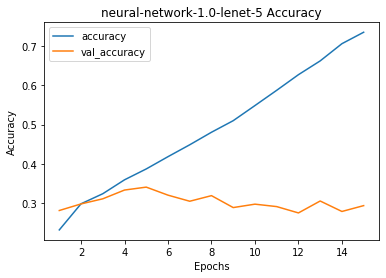

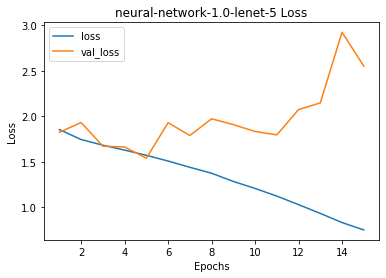

In [91]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-1.0-lenet-5 Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-1.0-lenet-5 Loss')

Predictions: [[0. 1. 0. 0. 0. 0. 0.]].


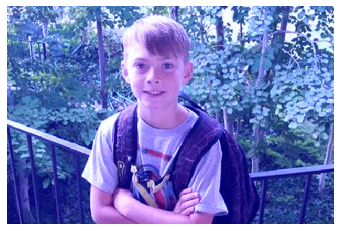

In [113]:
# Plot image activation
best_val_score = 'models-and-results-UTKface_inthewild-balanced/neural-network-1.0-lenet-5-weights-0.34.h5'
model_path     = 'models-and-results-UTKface_inthewild-balanced/neural-network-1.0-lenet-5-model.h5'

plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\20\11_0_0_20170110225459361.jpg')

Predictions: [[1.0000000e+00 2.7741425e-19 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]].


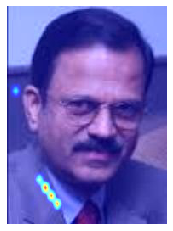

In [114]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\60\52_0_3_20170109142447723.jpg')

Predictions: [[0. 1. 0. 0. 0. 0. 0.]].


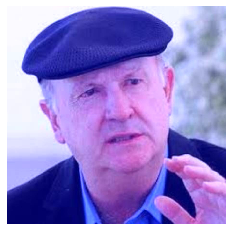

In [115]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\70\67_0_0_20170117204838537.jpg')

<br><br><br><br><br><br><br><br>
# Neural Network 1.1 - LeNet-5 CNN Architecture - BatchNormalization/Softmax
Modified the original LeNet-5 structure by:
* 1. Adding **two** BatchNormalization() layers **after** the Conv2D layers. 
* 2. Adding changing the output layers to an activation **softmax** instead of the **assumed** relu.

<br><br>
## Functions

In [106]:
def build_dense_model():
    """
    This function creates a simple sequential neural network.
    """
    # Sequential model
    model = models.Sequential() 
    
    # Hidden layers
    model.add(layers.Conv2D(filters     = 6, 
                            kernel_size = (3,3), 
                            activation  = 'relu', 
                            input_shape = (32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2), 
                                      strides   = 1))
    
    model.add(layers.Conv2D(filters     = 16, 
                            kernel_size = (3,3), 
                            activation  = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2), 
                                      strides   = 1))    
    
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units = 120, 
                           activation='relu'))
    model.add(layers.Dense(units = 84, 
                           activation='relu'))
    
    # Output layer
    model.add(layers.Dense(units = 7, 
                           activation='softmax'))
    
    # Compiler
    model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])      
        
    return model

model = build_dense_model()
model.name='neural-network-1.1-LeNet-5-CNN-Architecture'
model.summary()

Model: "neural-network-1.1-LeNet-5-CNN-Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 6)         24        
_________________________________________________________________
average_pooling2d_3 (Average (None, 29, 29, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 16)        880       
_________________________________________________________________
batch_normalization_4 (Batch (None, 27, 27, 16)        64        
_________________________________________________________________
average_pooling2d_4 (Average (None, 26, 26, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)    

<br><br>
## Generator

In [107]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (32, 32)
COLOR_MODE  = 'grayscale'
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE)

Found 6243 images belonging to 7 classes.
Found 1646 images belonging to 7 classes.
Found 392 images belonging to 7 classes.


<br><br><br>
## Run the model

In [108]:
K.clear_session()

model = build_dense_model()
model.name='neural-network-1.1-LeNet-5-CNN-Architecture'
model.summary()

Model: "neural-network-1.1-LeNet-5-CNN-Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 6)         24        
_________________________________________________________________
average_pooling2d_1 (Average (None, 29, 29, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 16)        880       
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 27, 16)        64        
_________________________________________________________________
average_pooling2d_2 (Average (None, 26, 26, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)    

In [110]:
filepath = "models-and-results-UTKface_inthewild-balanced/neural-network-1.1-lenet-5-weights-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              workers             = (multiprocessing.cpu_count()),
                              callbacks           = callbacks_list
                             )

Epoch 1/15
195/195 [==============================] - 24s 125ms/step - loss: 1.9913 - accuracy: 0.2686 - val_loss: 2.0036 - val_accuracy: 0.1336

Epoch 00001: val_accuracy improved from -inf to 0.13358, saving model to models-and-results-UTKface_inthewild-balanced/neural-network-1.1-lenet-5-weights-0.13.h5
Epoch 2/15
195/195 [==============================] - 24s 123ms/step - loss: 1.4990 - accuracy: 0.4339 - val_loss: 2.0276 - val_accuracy: 0.1512

Epoch 00002: val_accuracy improved from 0.13358 to 0.15118, saving model to models-and-results-UTKface_inthewild-balanced/neural-network-1.1-lenet-5-weights-0.15.h5
Epoch 3/15
195/195 [==============================] - 25s 130ms/step - loss: 0.9725 - accuracy: 0.6529 - val_loss: 2.3465 - val_accuracy: 0.2385

Epoch 00003: val_accuracy improved from 0.15118 to 0.23854, saving model to models-and-results-UTKface_inthewild-balanced/neural-network-1.1-lenet-5-weights-0.24.h5
Epoch 4/15
195/195 [==============================] - 25s 127ms/step -

<br><br><br>
## Save results and plot results

In [116]:
# Save results
# model.save_weights('models-and-results-UTKface_inthewild-balanced/neural-network-1.1-lenet-5-weights.h5')
model.save('models-and-results-UTKface_inthewild-balanced/neural-network-1.1-lenet-5-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-1.1-lenet-5-history', 
                   storage_location = 'models-and-results-UTKface_inthewild-balanced')

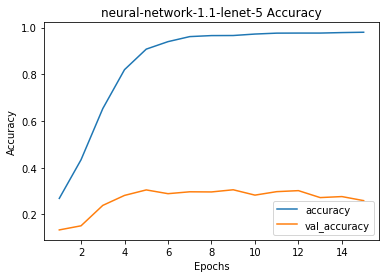

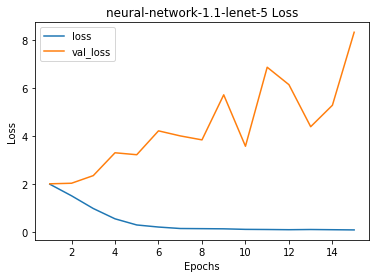

In [117]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-1.1-lenet-5 Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-1.1-lenet-5 Loss')

Predictions: [[1. 0. 0. 0. 0. 0. 0.]].


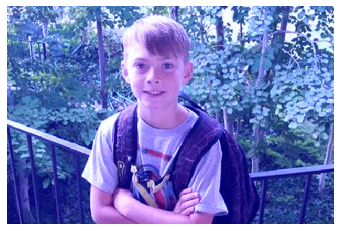

In [118]:
# Plot image activation
best_val_score = 'models-and-results-UTKface_inthewild-balanced/neural-network-1.1-lenet-5-weights-0.31.h5'
model_path     = 'models-and-results-UTKface_inthewild-balanced/neural-network-1.1-lenet-5-model.h5'

plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\20\11_0_0_20170110225459361.jpg')

Predictions: [[1. 0. 0. 0. 0. 0. 0.]].


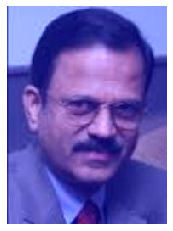

In [119]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\60\52_0_3_20170109142447723.jpg')

Predictions: [[0. 0. 0. 0. 0. 1. 0.]].


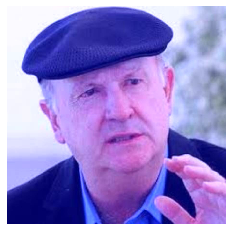

In [120]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\70\67_0_0_20170117204838537.jpg')

------

<br><br><br><br>
# Neural Network 2.0 - LeNet-5 CNN (proposed improved version)

<br><br>
## Functions

In [121]:
def build_model():
    """
    This function creates a simple sequential neural network.
    """
    # Sequential model
    model = models.Sequential() 
    
    # Hidden layers
    model.add(layers.Conv2D(filters     = 6, 
                            kernel_size = (7, 7),        # Fiters from (3, 3) to (7, 7)
                            activation  = 'relu', 
                            input_shape = (200, 200, 3)))
    model.add(layers.MaxPooling2D(pool_size = (2,2), 
                                      strides   = 2))     # Assumed based on trial and error, not mentioned in the paper
    
    model.add(layers.Conv2D(filters     = 16, 
                            kernel_size = (3,3), 
                            activation  = 'relu'))
    model.add(layers.MaxPooling2D(pool_size = (2,2), 
                                      strides   = 2))     # Assumed based on trial and error, not mentioned in the paper
    
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units = 120, 
                           activation='relu'))
    model.add(layers.Dropout(rate = 0.5))                # Dropout layer added
    
    # Output layer
    model.add(layers.Dense(units = 7, 
                           activation='softmax'))        # Softmax instead of relu
    
    # Compiler
    model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])      
        
    return model

<br><br>
## Generator

In [122]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (200, 200)
COLOR_MODE  = 'rgb'
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE)

Found 6243 images belonging to 7 classes.
Found 1646 images belonging to 7 classes.
Found 392 images belonging to 7 classes.


<br><br><br>
## Run the model

In [123]:
K.clear_session()

model = build_model()
model.name='neural-network-2.0-LeNet-5-proposed-improved-CNN-Architecture'
model.summary()


Model: "neural-network-2.0-LeNet-5-proposed-improved-CNN-Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 194, 194, 6)       888       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 97, 97, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 95, 95, 16)        880       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 35344)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               4241400   
_________________________________________________________________
drop

In [124]:
filepath = "models-and-results-UTKface_inthewild-balanced/neural-network-2.0-lenet-5-proposed-model-weights-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              workers             = (multiprocessing.cpu_count()),
                              callbacks           = callbacks_list
                             )

Epoch 1/15
195/195 [==============================] - 134s 688ms/step - loss: 2.2236 - accuracy: 0.2011 - val_loss: 1.8138 - val_accuracy: 0.2966

Epoch 00001: val_accuracy improved from -inf to 0.29657, saving model to models-and-results-UTKface_inthewild-balanced/neural-network-2.0-lenet-5-proposed-model-weights-0.30.h5
Epoch 2/15
195/195 [==============================] - 129s 662ms/step - loss: 1.7836 - accuracy: 0.2909 - val_loss: 1.6652 - val_accuracy: 0.2912

Epoch 00002: val_accuracy did not improve from 0.29657
Epoch 3/15
195/195 [==============================] - 133s 681ms/step - loss: 1.6527 - accuracy: 0.3645 - val_loss: 1.4627 - val_accuracy: 0.3191

Epoch 00003: val_accuracy improved from 0.29657 to 0.31908, saving model to models-and-results-UTKface_inthewild-balanced/neural-network-2.0-lenet-5-proposed-model-weights-0.32.h5
Epoch 4/15
195/195 [==============================] - 127s 651ms/step - loss: 1.4602 - accuracy: 0.4513 - val_loss: 1.7932 - val_accuracy: 0.3240



<br><br><br>
## Save results and plot results

In [125]:
# Save results
# model.save_weights('models-and-results-UTKface_inthewild-balanced/neural-network-2.0-lenet-5-proposed-model-weights.h5')
model.save('models-and-results-UTKface_inthewild-balanced/neural-network-2.0-lenet-5-proposed-model-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-2.0-lenet-5-proposed-model-history', 
                   storage_location = 'models-and-results-UTKface_inthewild-balanced')

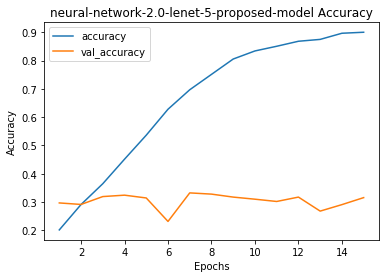

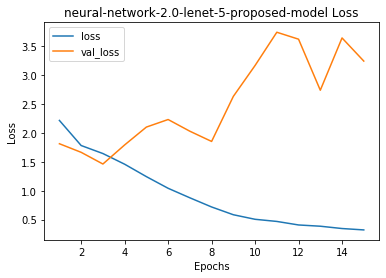

In [126]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-2.0-lenet-5-proposed-model Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-2.0-lenet-5-proposed-model Loss')

Predictions: [[0. 0. 1. 0. 0. 0. 0.]].


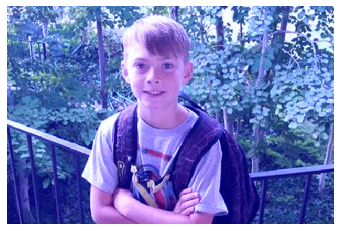

In [127]:
# Plot image activation
best_val_score = 'models-and-results-UTKface_inthewild-balanced/neural-network-2.0-lenet-5-proposed-model-weights-0.33.h5'
model_path     = 'models-and-results-UTKface_inthewild-balanced/neural-network-2.0-lenet-5-proposed-model-model.h5'

plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\20\11_0_0_20170110225459361.jpg')

Predictions: [[0. 0. 1. 0. 0. 0. 0.]].


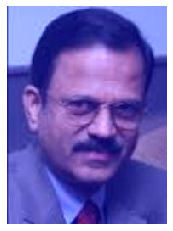

In [128]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\60\52_0_3_20170109142447723.jpg')

Predictions: [[0. 0. 1. 0. 0. 0. 0.]].


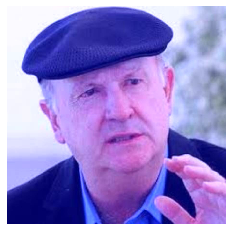

In [129]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\70\67_0_0_20170117204838537.jpg')

------

<br><br><br><br>
# Neural Network 3.0 - Transfer Learning - VGG16

<br><br>
## Define/import the model

In [13]:
K.clear_session()

# Generate model without top layers
vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape=(200, 200, 3))

# Extract information of the last layer of VGG16
layer_dict = dict([(layer.name, layer) for layer in vgg16.layers])
x = layer_dict[vgg16.layers[-1].name].output

# Add layers
x = Flatten()(x)
x = Dense(512, activation='relu', name='fc1')(x)           # Change this to 512 instead of 4096
x = Dense(512, activation='relu', name='fc2')(x)           # Change this to 512 instead of 4096
x = Dense(7, activation='softmax', name='predictions')(x)  # Output layer

# Combine vgg16 layer with my own layers
model = Model(input = vgg16.input, output = x)

# Freeze everything EXCEPT the last 2 FC layers (of the 3)
for layer in model.layers[:-2]:
    layer.trainable = False
    
# Add compiler
model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 

# Name the model
model.name='neural-network-3.0-transfer-learning-vgg16'

# Show summary
model.summary()


Model: "neural-network-3.0-transfer-learning-vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling

C:\Users\Paulo\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`


<br><br>
## Generator

In [14]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (200, 200)
COLOR_MODE  = 'rgb'      # Model VVG16 expects rgb
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE)

Found 6243 images belonging to 7 classes.
Found 1646 images belonging to 7 classes.
Found 392 images belonging to 7 classes.


<br><br><br>
## Run the model

In [15]:
filepath = "models-and-results-UTKface_inthewild-balanced/neural-network-3.0-transfer-learning-vgg16-weights-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              callbacks           = callbacks_list,
                              workers             = (multiprocessing.cpu_count())
                             )


Epoch 1/15
195/195 [==============================] - 1674s 9s/step - loss: 1.8502 - accuracy: 0.2576 - val_loss: 1.5955 - val_accuracy: 0.2947

Epoch 00001: val_accuracy improved from -inf to 0.29473, saving model to models-and-results-UTKface_inthewild-balanced/neural-network-3.0-transfer-learning-vgg16-weights-0.29.h5
Epoch 2/15
195/195 [==============================] - 1642s 8s/step - loss: 1.6181 - accuracy: 0.3479 - val_loss: 1.5666 - val_accuracy: 0.3625

Epoch 00002: val_accuracy improved from 0.29473 to 0.36245, saving model to models-and-results-UTKface_inthewild-balanced/neural-network-3.0-transfer-learning-vgg16-weights-0.36.h5
Epoch 3/15
195/195 [==============================] - 1641s 8s/step - loss: 1.5438 - accuracy: 0.3803 - val_loss: 1.4103 - val_accuracy: 0.3872

Epoch 00003: val_accuracy improved from 0.36245 to 0.38724, saving model to models-and-results-UTKface_inthewild-balanced/neural-network-3.0-transfer-learning-vgg16-weights-0.39.h5
Epoch 4/15
195/195 [====

KeyboardInterrupt: 

<br><br><br>
## Save results and plot results

In [16]:
# Save results
# model.save_weights('models-and-results-UTKface_inthewild-balanced/neural-network-3.0-transfer-learning-vgg16-weights.h5')
model.save('models-and-results-UTKface_inthewild-balanced/neural-network-3.0-transfer-learning-vgg16-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-3.0-transfer-learning-vgg16-history', 
                   storage_location = 'models-and-results-UTKface_inthewild-balanced')

NameError: name 'history' is not defined

In [ ]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-3.0-transfer-learning-vgg16 Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-3.0-transfer-learning-vgg16 Loss')

Predictions: [[6.7628084e-22 1.0000000e+00 6.4717997e-23 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.2246038e-38]].


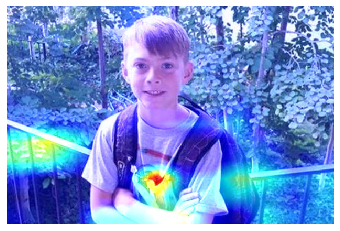

In [19]:
# Plot image activation
best_val_score = 'models-and-results-UTKface_inthewild-balanced/neural-network-3.0-transfer-learning-vgg16-weights-0.39.h5'
model_path     = 'models-and-results-UTKface_inthewild-balanced/neural-network-3.0-transfer-learning-vgg16-model.h5'

plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\20\11_0_0_20170110225459361.jpg')

Predictions: [[1.8883886e-36 1.0000000e+00 3.0090459e-16 8.9391512e-31 1.4299334e-30
  4.1096283e-25 4.1211190e-33]].


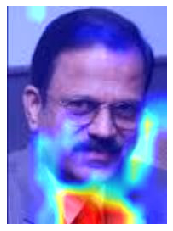

In [20]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\60\52_0_3_20170109142447723.jpg')

Predictions: [[0.0000000e+00 1.0000000e+00 3.5727942e-26 0.0000000e+00 0.0000000e+00
  0.0000000e+00 4.3115682e-34]].


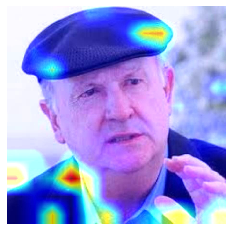

In [21]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_inthewild-new-structure-balanced\test\70\67_0_0_20170117204838537.jpg')